2.a) f_fast = 0.48726; f_general = 0.48726


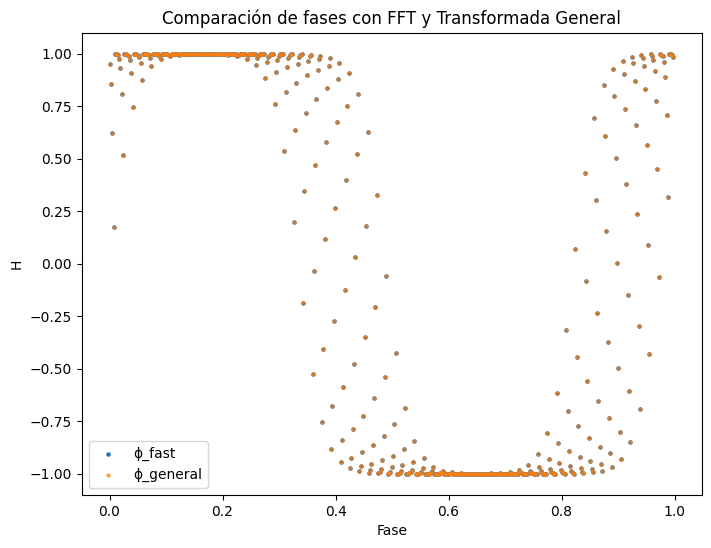

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("H_field.csv")
t = data.iloc[:, 0].values
H = data.iloc[:, 1].values

dt = np.mean(np.diff(t))  # Intervalo de tiempo promedio

H_fft = np.fft.rfft(H)
freqs = np.fft.rfftfreq(len(H), dt)

f_fast = freqs[np.argmax(np.abs(H_fft))]

def Fourier(t, y, f):
    return np.sum(y * np.exp(-2j * np.pi * f * t))

f_general = freqs[np.argmax([np.abs(Fourier(t, H, f)) for f in freqs])]

phi_fast = (f_fast * t) % 1
phi_general = (f_general * t) % 1

plt.figure(figsize=(8, 6))
plt.scatter(phi_fast, H, s=5, label="ϕ_fast")
plt.scatter(phi_general, H, s=5, label="ϕ_general", alpha=0.6)
plt.xlabel("Fase")
plt.ylabel("H")
plt.legend()
plt.title("Comparación de fases con FFT y Transformada General")
plt.savefig("2.a.pdf")

print(f"2.a) {f_fast = :.5f}; {f_general = :.5f}")

2.a) f_rapida = 0.49979; f_general = 0.49868


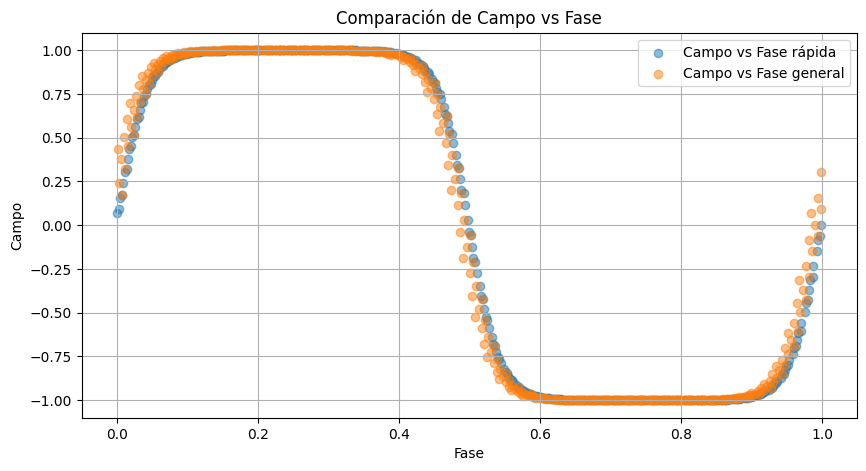

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

datos = pd.read_csv('H_field.csv')
datos.columns = ['tiempo', 'campo']

tiempo = datos['tiempo'].values
campo = datos['campo'].values

delta_t = np.mean(np.diff(tiempo))
n = len(tiempo)

n_fft = 100 * n  # Incremento de resolución al 400%
fft_campo = np.fft.rfft(campo, n=n_fft)
frecuencias = np.fft.rfftfreq(n_fft, delta_t)

indice_max = np.argmax(np.abs(fft_campo[1:])) + 1
f_rapida = frecuencias[indice_max]

def transformada_fourier(t, y, f):
    return np.sum(y * np.exp(-2j * np.pi * f * t))

rango_frec = np.linspace(0, frecuencias[-1], 1000)
magnitudes = np.array([np.abs(transformada_fourier(tiempo, campo, f)) for f in rango_frec])
indice_general = np.argmax(magnitudes)
f_general = rango_frec[indice_general]

print(f"2.a) f_rapida = {f_rapida:.5f}; f_general = {f_general:.5f}")

fase_rapida = np.mod(f_rapida * tiempo, 1)
fase_general = np.mod(f_general * tiempo, 1)

plt.figure(figsize=(10,5))
plt.scatter(fase_rapida, campo, label='Campo vs Fase rápida', alpha=0.5)
plt.scatter(fase_general, campo, label='Campo vs Fase general', alpha=0.5)
plt.xlabel('Fase')
plt.ylabel('Campo')
plt.legend()
plt.title('Comparación de Campo vs Fase')
plt.grid()
plt.savefig('2.a.pdf')
plt.show()


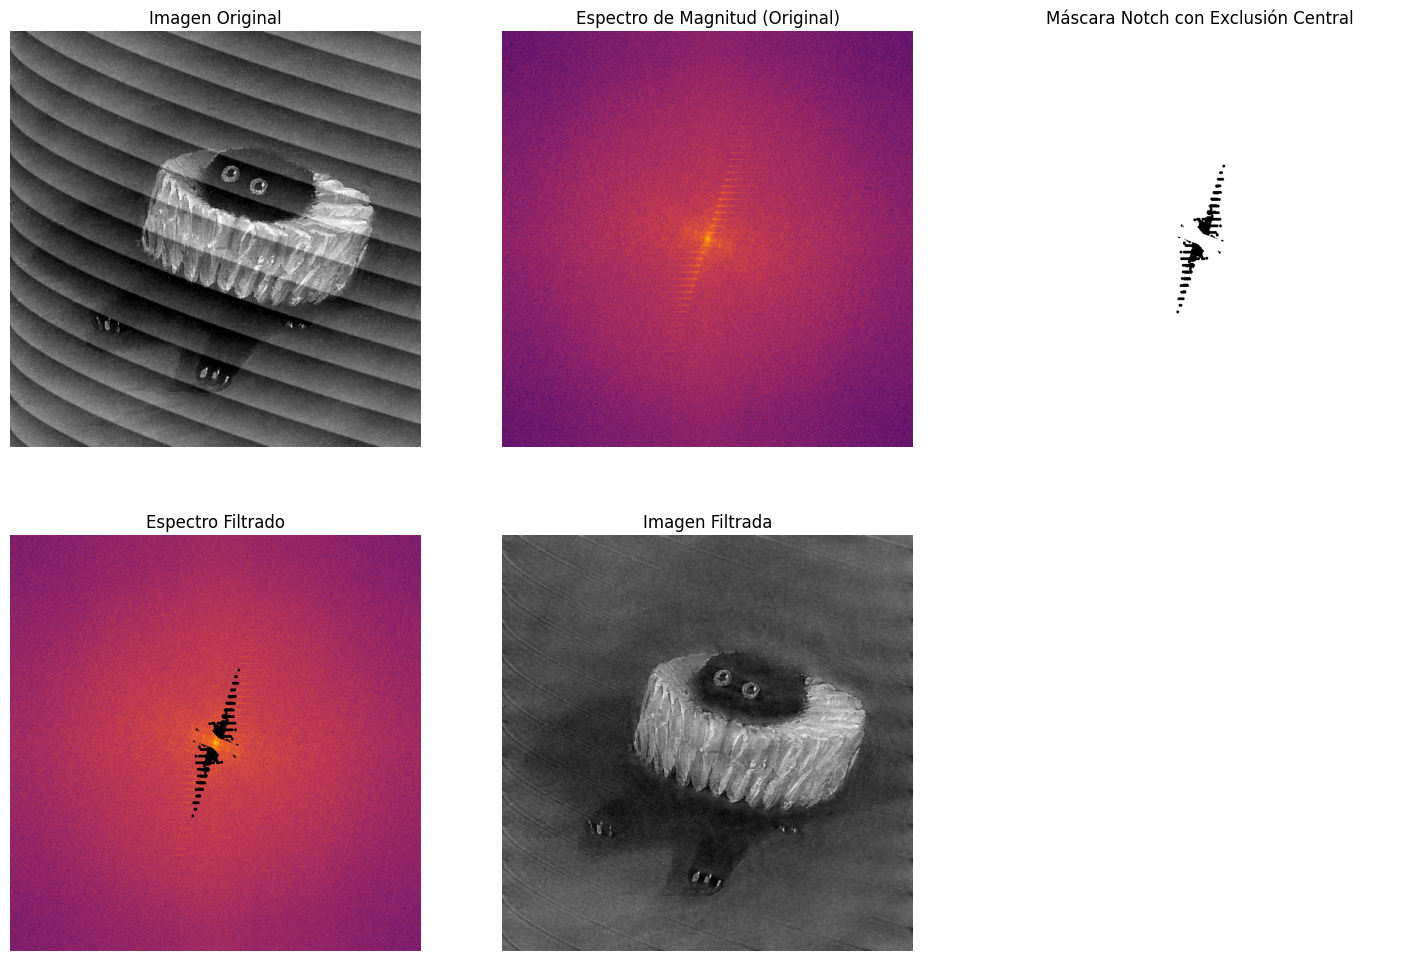

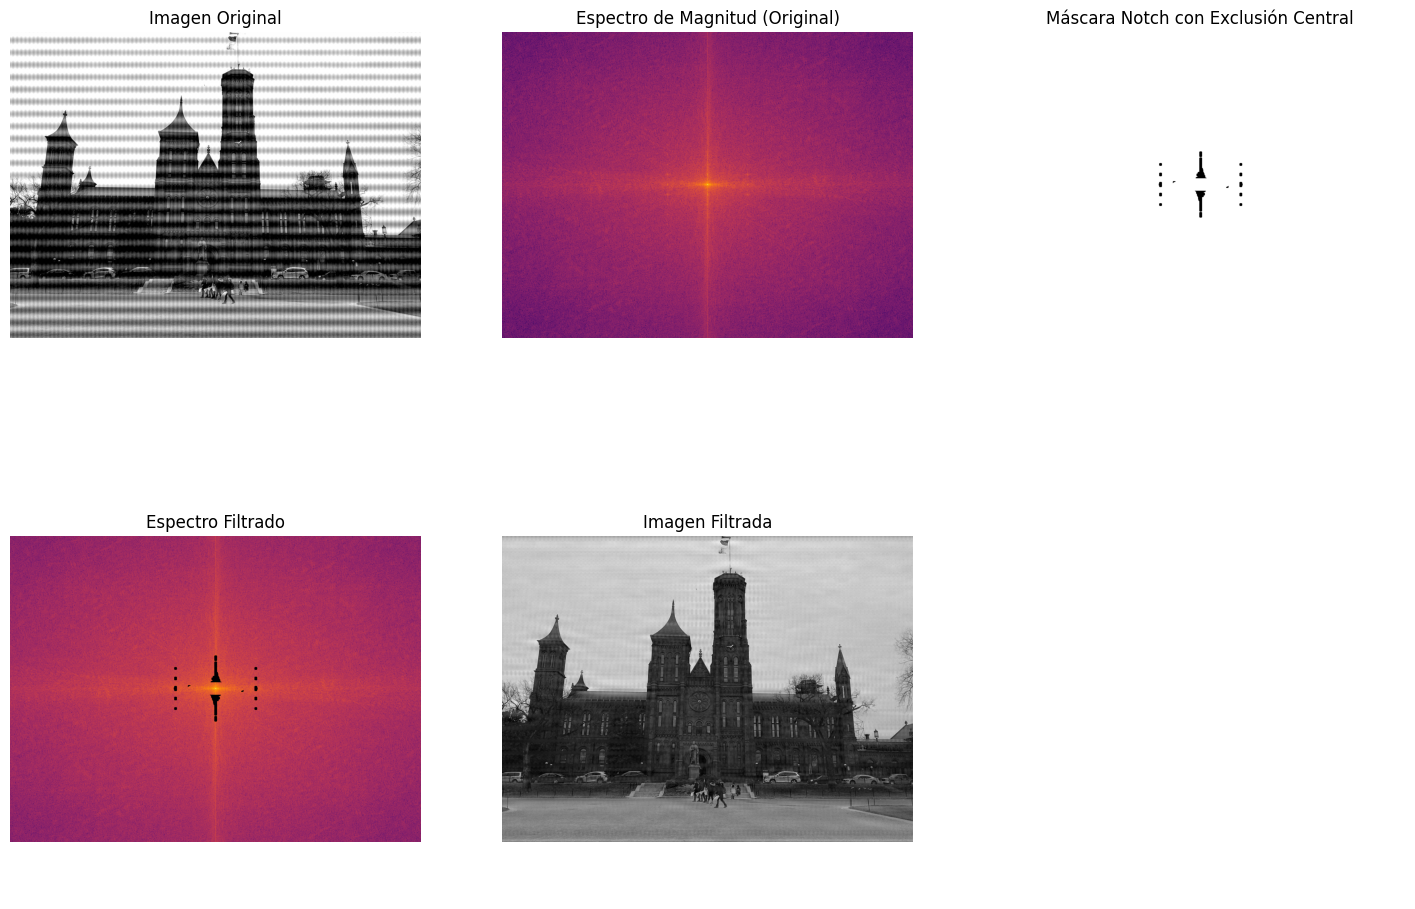

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_dilation, generate_binary_structure

def detectar_picos_de_ruido_adaptativo(espectro, proporcion_umbral=0.6, iteraciones_dilatacion=2):
    """Detecta picos de ruido en el espectro de frecuencia usando umbralización adaptativa y dilatación."""
    max_val = np.max(espectro)
    mascara_binaria = espectro > (proporcion_umbral * max_val)

    estructura = generate_binary_structure(2, 2)
    mascara_dilatada = binary_dilation(mascara_binaria, structure=estructura, iterations=iteraciones_dilatacion)

    etiquetado, num_caracteristicas = label(mascara_dilatada)
    return np.argwhere(etiquetado > 0), mascara_dilatada

def eliminar_ruido_periodico_adaptativo(img, proporcion_umbral=0.6, radio_notch=10, iteraciones_dilatacion=2,
                                        radio_central_x=30, radio_central_y=10, angulo=15, extra_elipse=False,
                                        radio_extra_x=20, radio_extra_y=15, angulo_extra=45):
    """Elimina el ruido periódico de una imagen mediante filtrado notch adaptativo, excluyendo el centro."""
    filas, columnas = img.shape
    centro = (columnas // 2, filas // 2)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    espectro_magnitud = np.log1p(np.abs(fshift))

    picos_de_ruido, mascara_dilatada = detectar_picos_de_ruido_adaptativo(espectro_magnitud, proporcion_umbral, iteraciones_dilatacion)
    mascara_notch = np.ones((filas, columnas), np.float32)

    for pico in np.argwhere(mascara_dilatada):
        cv2.circle(mascara_notch, tuple(pico[::-1]), radio_notch, 0, -1)

    # Primera elipse protectora
    cv2.ellipse(mascara_notch, centro, (radio_central_x, radio_central_y), angulo, 0, 360, 1, -1)

    # Segunda elipse adicional para la imagen del gato
    if extra_elipse:
        cv2.ellipse(mascara_notch, centro, (radio_extra_x, radio_extra_y), angulo_extra, 0, 360, 1, -1)

    fshift_filtrado = fshift * mascara_notch
    f_ishift = np.fft.ifftshift(fshift_filtrado)
    img_filtrada = np.abs(np.fft.ifft2(f_ishift))

    return img_filtrada, espectro_magnitud, np.log1p(np.abs(fshift_filtrado)), mascara_notch

def procesar_imagen(ruta_imagen, proporcion_umbral, radio_notch, iteraciones_dilatacion, radio_central_x, radio_central_y, angulo=0, extra_elipse=False, radio_extra_x=20, radio_extra_y=15, angulo_extra=45):
    """Procesa una imagen para eliminar el ruido periódico."""
    img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: No se pudo cargar la imagen {ruta_imagen}")
        return

    img_filtrada, espectro_original, espectro_filtrado, mascara_notch = eliminar_ruido_periodico_adaptativo(
        img, proporcion_umbral, radio_notch, iteraciones_dilatacion, radio_central_x, radio_central_y, angulo, extra_elipse, radio_extra_x, radio_extra_y, angulo_extra
    )

    fig, ejes = plt.subplots(2, 3, figsize=(18, 12))
    ejes[0, 0].imshow(img, cmap='gray')
    ejes[0, 0].set_title("Imagen Original")
    ejes[0, 1].imshow(espectro_original, cmap='inferno')
    ejes[0, 1].set_title("Espectro de Magnitud (Original)")
    ejes[0, 2].imshow(mascara_notch, cmap='gray')
    ejes[0, 2].set_title("Máscara Notch con Exclusión Central")
    ejes[1, 0].imshow(espectro_filtrado, cmap='inferno')
    ejes[1, 0].set_title("Espectro Filtrado")
    ejes[1, 1].imshow(img_filtrada, cmap='gray')
    ejes[1, 1].set_title("Imagen Filtrada")
    ejes[1, 2].axis('off')

    for eje in ejes.flat:
        eje.axis("off")
    plt.show()

# Procesar la imagen del gato con la nueva elipse adicional configurada
procesar_imagen("catto.png", proporcion_umbral=0.65, radio_notch=1, iteraciones_dilatacion=1, radio_central_x=100, radio_central_y=10, angulo=20, extra_elipse=True, radio_extra_x=200, radio_extra_y=9, angulo_extra=50)

# Procesar la imagen del castillo sin cambios
procesar_imagen("Noisy_Smithsonian_Castle.jpg", proporcion_umbral=0.67, radio_notch=1, iteraciones_dilatacion=2, radio_central_x=70, radio_central_y=15, angulo=0, extra_elipse=False)


2.b.a) {P_solar = 10.97 años}
2.b.b) {n_manchas_hoy = 153.50}


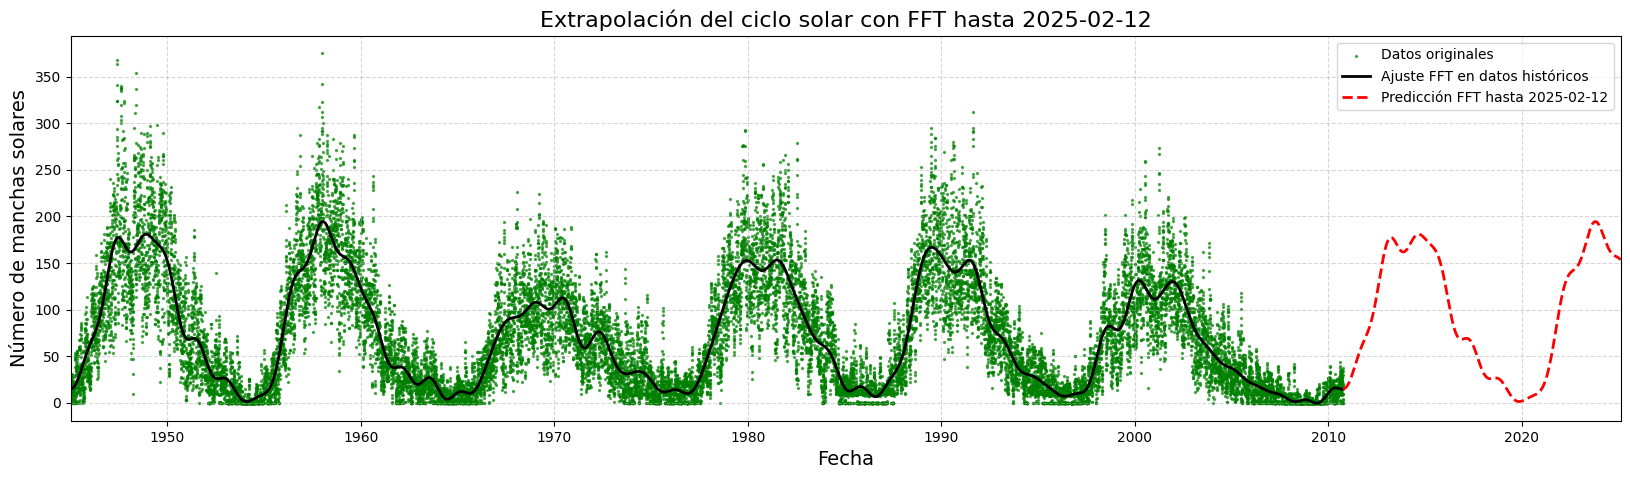

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_sunspot_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    # Buscar la línea donde empieza la tabla (se asume que la primera línea con "Year" es el encabezado)
    start_index = next(i for i, line in enumerate(lines) if line.strip().startswith("Year"))
    columns = ["Year", "Month", "Day", "SSN"]
    data_list = []
    for line in lines[start_index+1:]:
        parts = line.strip().split()
        if len(parts) == 4:
            try:
                data_list.append([int(parts[0]), int(parts[1]), int(parts[2]), int(parts[3])])
            except ValueError:
                continue
    df = pd.DataFrame(data_list, columns=columns)
    df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
    df = df.sort_values("Date")
    return df

# Configuraciones
data_file = "sun_data.txt"
fecha_limite_str = "2010-10-10"       # Fecha hasta la que se usan los datos históricos
fecha_extrapolacion_str = "2025-02-12"  # Fecha hasta la que se quiere extrapolar

# Cargar y filtrar datos
data = load_sunspot_data(data_file)
fecha_limite = pd.to_datetime(fecha_limite_str)
data = data[data["Date"] <= fecha_limite]

# Extraer la serie de tiempo
N = len(data)
t = np.arange(N)
y = data["SSN"].values

# Aplicar FFT completa
X_fft = np.fft.fft(y)

# Calcular la frecuencia dominante (ignorando la componente DC) y su período en años
freqs_full = np.fft.fftfreq(N, d=1)  # en ciclos por día
dominant_index = np.argmax(np.abs(X_fft[1:N//2])) + 1
dominant_freq = np.abs(freqs_full[dominant_index])
P_solar = 1 / dominant_freq / 365  # conversión de días a años
print(f'2.b.a) {{P_solar = {P_solar:.2f} años}}')

# Truncar los coeficientes: usar los primeros M armónicos
M = 50
X_fft_trunc = np.zeros_like(X_fft, dtype=complex)
# Se conserva el componente DC y las M frecuencias positivas
X_fft_trunc[:M+1] = X_fft[:M+1]
# Se conservan las correspondientes frecuencias negativas (excepto DC)
if M > 1:
    X_fft_trunc[-(M-1):] = X_fft[-(M-1):]

# Reconstruir la señal ajustada en el intervalo original
y_fit = np.fft.ifft(X_fft_trunc).real

# Función para extrapolar evaluando la serie de Fourier
def extrapolate_fourier(X_trunc, t_eval, N, M):
    # Índices de los armónicos: 0 a M y los correspondientes negativos
    pos_indices = np.arange(0, M+1)
    neg_indices = np.arange(N - (M-1), N) if M > 1 else np.array([], dtype=int)
    k_indices = np.concatenate((pos_indices, neg_indices))
    X_reduced = X_trunc[k_indices]
    # y(t) = (1/N) * sum_{k in k_indices} X[k] exp(2πi * k * t / N)
    exponent = 2j * np.pi * np.outer(t_eval, k_indices) / N
    y_extrap = np.dot(np.exp(exponent), X_reduced) / N
    return y_extrap.real

# Preparar extrapolación
fecha_inicio_extrapolacion = data["Date"].max()
fecha_extrapolacion = pd.to_datetime(fecha_extrapolacion_str)
# Se suma 1 para incluir el último día en el rango de extrapolación
dias_extrapolacion = (fecha_extrapolacion - fecha_inicio_extrapolacion).days + 1

t_future = np.arange(N, N + dias_extrapolacion)
y_extrap = extrapolate_fourier(X_fft_trunc, t_future, N, M)

# Predicción del número de manchas solares en la fecha final
n_manchas_hoy = y_extrap[-1]
print(f'2.b.b) {{n_manchas_hoy = {n_manchas_hoy:.2f}}}')

# Crear rango de fechas para la extrapolación
future_dates = pd.date_range(start=fecha_inicio_extrapolacion, periods=dias_extrapolacion, freq="D")

# Graficar: datos originales, ajuste en el intervalo conocido y extrapolación
plt.figure(figsize=(20, 5), dpi=100)
plt.scatter(data["Date"], y, s=2, color='green', alpha=0.6, label="Datos originales")
plt.plot(data["Date"], y_fit, color='black', linewidth=2, label="Ajuste FFT en datos históricos")
plt.plot(future_dates, y_extrap, color="red", linewidth=2, linestyle='dashed',
         label=f"Predicción FFT hasta {fecha_extrapolacion.strftime('%Y-%m-%d')}")
# Asegurarse de que el eje x abarque desde la primera fecha hasta la fecha final de extrapolación
plt.xlim(data["Date"].min(), fecha_extrapolacion)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Número de manchas solares", fontsize=14)
plt.title(f"Extrapolación del ciclo solar con FFT hasta {fecha_extrapolacion.strftime('%Y-%m-%d')}", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
